In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import time
import cv2

from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, Input, Flatten, Activation
from keras.layers.merge import Concatenate, add
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


(9, 75, 75)
(9, 75, 75)


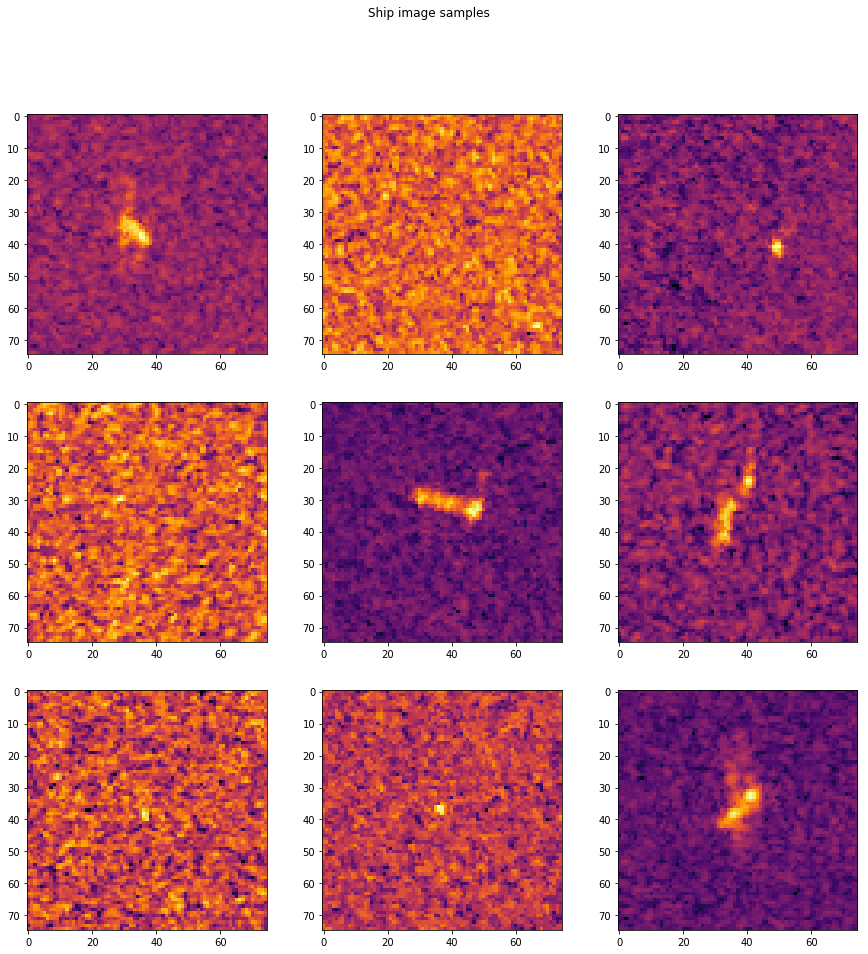

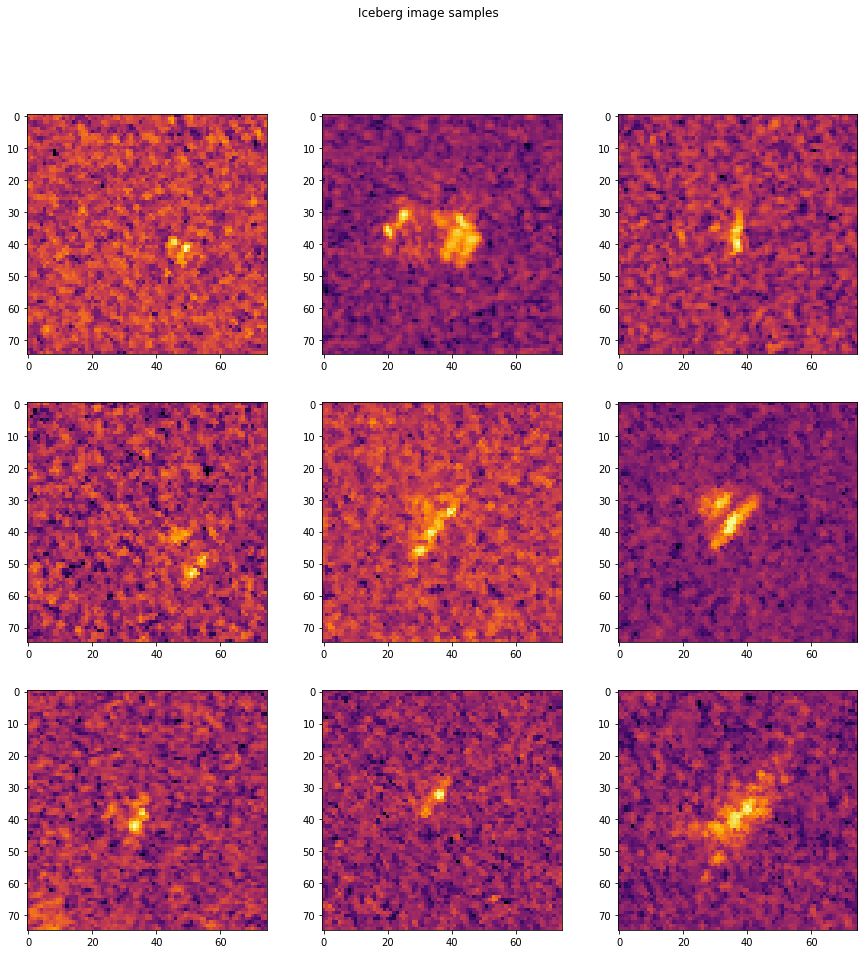

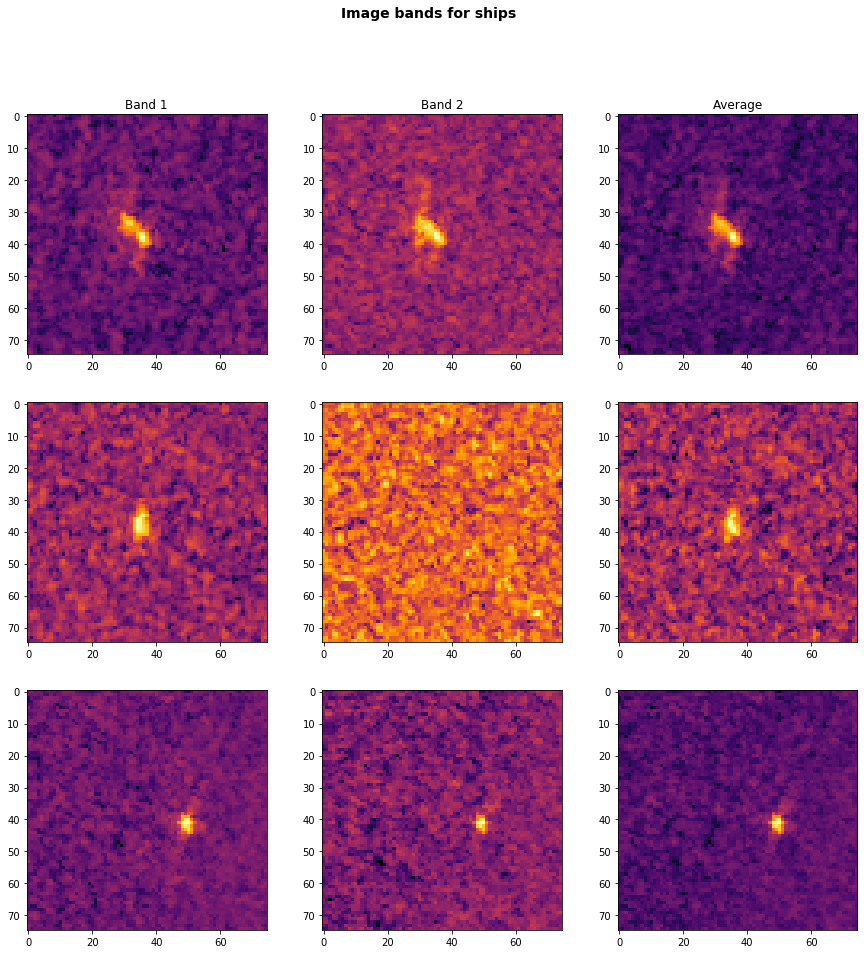

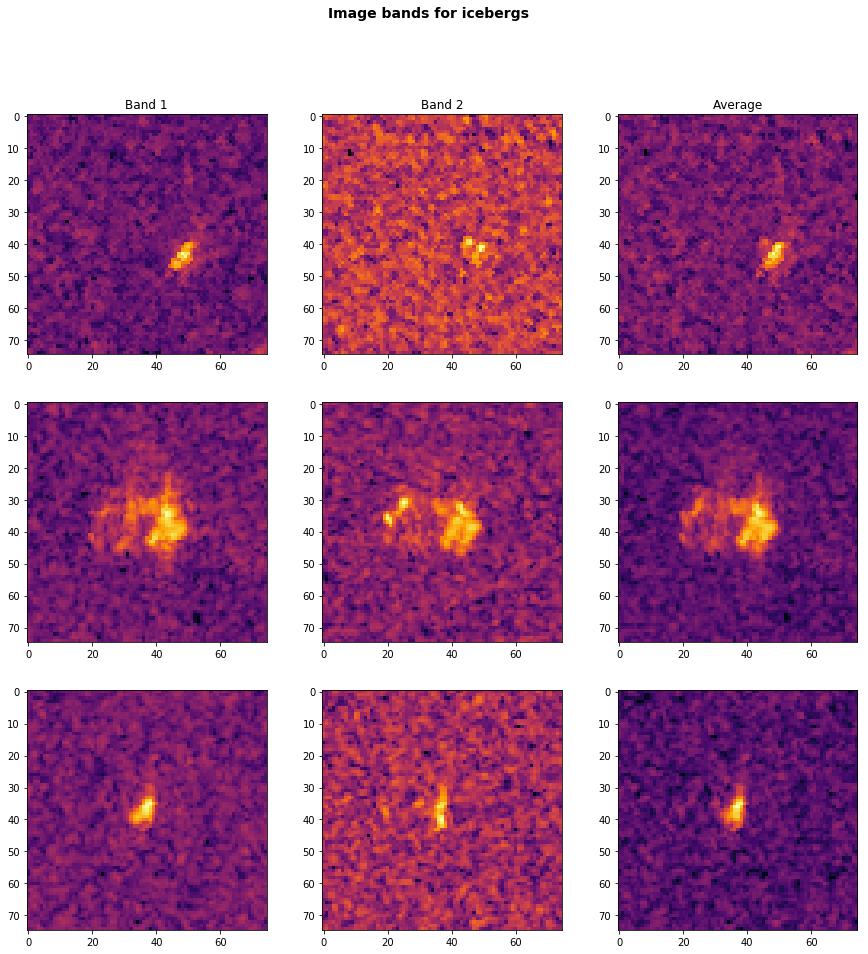

In [3]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

def generate_data( data ):
    X_band_1=np.array( [np.array(band).astype(np.float32).reshape(75, 75) 
                        for band in data['band_1']] )
    print X_band_1.shape
    X_band_2=np.array( [np.array(band).astype(np.float32).reshape(75, 75) 
                        for band in data['band_2']] )
    X = np.concatenate( [X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis], \
                        ((X_band_1 + X_band_2)/2)[:, :, :, np.newaxis]], axis=-1 )
    return X

def augment_data( generator, X1, X2, y, batch_size = 32 ):
    generator_seed = np.random.randint( 9999 )
    gen_X1 = generator.flow( X1, y, batch_size = batch_size, seed = generator_seed )
    gen_X2 = generator.flow( X1, X2, batch_size = batch_size, seed = generator_seed )

    while True:
        X1i = gen_X1.next()
        X2i = gen_X2.next()

        yield [ X1i[0], X2i[1] ], X1i[1]
    
def plot_band_samples( data, band = 1, title = None ):
    fig = plt.figure( 1, figsize=(15, 15) )
    for i in range(9):
        ax = fig.add_subplot( 3, 3, i + 1 )
        arr = np.reshape( np.array(data.iloc[i, band - 1]), (75, 75) )
        ax.imshow( arr, cmap='inferno' )
        fig.suptitle( title )

    plt.show()

def plot_all_bands( data, title = None ):
    fig = plt.figure( 1, figsize = (15, 15) )
    count = 1
    for i in range(3):
        for j in range(3):
            ax = fig.add_subplot( 3, 3, count )
            ax.imshow( data[i, :, :, j], cmap = 'inferno' )
            count += 1
            if i == 0:
                if j == 0:
                    ax.set_title( 'Band 1' , fontsize = 12)
                elif j == 1:
                    ax.set_title( 'Band 2', fontsize = 12 )
                elif j == 2:
                    ax.set_title( 'Average', fontsize = 12 )
    fig.suptitle( title, fontsize = 14, fontweight = 'bold' )
    plt.show()

def make_plots( data, band_samples = True, all_bands = True ):
    ships = data[ data.is_iceberg == 0 ].sample( n = 9, random_state = 42 )
    icebergs = data[ data.is_iceberg == 1 ].sample( n = 9, random_state = 42 )
#     print (ships.shape)
#     print type(ships)
    np_ships = generate_data( ships )
    np_icebergs = generate_data( icebergs )
#     print (np_ships.shape)
#     print type(np_ships)
    if band_samples:
        plot_band_samples( ships, band = 2, title = 'Ship image samples' )
        plot_band_samples( icebergs, band = 2, title = 'Iceberg image samples' )

    if all_bands:
        plot_all_bands( np_ships, 'Image bands for ships' )
        plot_all_bands( np_icebergs, 'Image bands for icebergs' )

 
 
 
TEST = True # Should test data be passed to the model?
DO_PLOT = True # Exploratory data plots
USE_AUGMENTATION = False # Whether or not image augmentations should be made
TRAIN_PATH = 'kaggle_lceberg_data/train.json'
TEST_PATH = 'kaggle_lceberg_data/test.json'
WEIGHT_SAVE_PATH = 'model_weights.hdf5'
PREDICTION_SAVE_PATH = 'kaggle_lceberg_data/submission'

if TEST:
    SEED = np.random.randint( 9999 )
else:
    SEED = 42 # Constant seed for comparability between runs

BATCH_SIZE = 16
EPOCHS = 60 # Increase this

train_data = pd.read_json( TRAIN_PATH )
# train_data[ 'inc_angle' ] = train_data[ 'inc_angle' ].replace('na', 0)
# train_data[ 'inc_angle' ] = train_data[ 'inc_angle' ].astype(float).fillna(0.0)

# X = generate_data( train_data )
X = get_scaled_imgs(train_data)
X_a = train_data[ 'inc_angle' ]
y = train_data[ 'is_iceberg' ]

train_data.inc_angle = train_data.inc_angle.replace('na',0)
idx_tr = np.where(train_data.inc_angle>0)


y = y[idx_tr[0]]
X_a = X_a[idx_tr[0]]
X = X[idx_tr[0],...]

def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images


# X = get_more_images(X)
# X_a = np.concatenate((X_a,X_a,X_a))
# y = np.concatenate((y,y,y))

# X = get_more_images(X)
# X_a = np.concatenate((X_a,X_a,X_a))
# y = np.concatenate((y,y,y))

if DO_PLOT:
    make_plots( train_data, band_samples = True, all_bands = True )

In [8]:
a = np.array(range(10))
b = np.zeros(10)
b[2], b[5], b[8] = 1, 1, 1
print a, b

[0 1 2 3 4 5 6 7 8 9] [ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.]


In [10]:
print a[b==0]

[0 1 3 4 6 7 9]


In [12]:
print y_val

NameError: name 'y_val' is not defined

In [13]:
X_train, X_val, X_angle_train, X_angle_val, y_train, y_val = train_test_split( X, X_a, y, train_size = .9, random_state = SEED )
print y_val

1022    1
256     0
335     1
1357    1
1008    0
1429    1
610     1
1146    1
312     0
1342    0
1335    1
1502    1
1488    0
1351    0
280     0
593     1
1059    0
129     0
994     1
1394    0
83      1
489     1
1262    0
1453    0
39      1
65      0
928     0
1144    0
1339    1
814     1
       ..
55      0
1023    1
1082    0
1230    0
210     1
857     1
15      0
344     0
1482    0
694     1
302     1
695     1
271     1
1501    1
1153    0
681     0
675     0
1011    1
357     0
79      0
219     0
710     0
483     1
1067    0
166     0
1271    0
415     0
1010    1
1111    1
891     1
Name: is_iceberg, Length: 148, dtype: int64


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
print y_val[:10]

1022    1
256     0
335     1
1357    1
1008    0
1429    1
610     1
1146    1
312     0
1342    0
Name: is_iceberg, dtype: int64
